In [157]:
import pandas as pd
import numpy as np

In [228]:
r1d0_data = pd.read_csv("./island-data-bottle-round-5/trades_round_1_day_0_wn.csv")
r1d1_data = pd.read_csv("./island-data-bottle-round-5/trades_round_1_day_-1_wn.csv")
r1d2_data = pd.read_csv("./island-data-bottle-round-5/trades_round_1_day_-2_wn.csv")

r2d0_data = pd.read_csv("./island-data-bottle-round-5/trades_round_2_day_0_wn.csv")
r2d1_data = pd.read_csv("./island-data-bottle-round-5/trades_round_2_day_1_wn.csv")
r2d2_data = pd.read_csv("./island-data-bottle-round-5/trades_round_2_day_-1_wn.csv")

r3d0_data = pd.read_csv("./island-data-bottle-round-5/trades_round_3_day_0_wn.csv")
r3d1_data = pd.read_csv("./island-data-bottle-round-5/trades_round_3_day_1_wn.csv")
r3d2_data = pd.read_csv("./island-data-bottle-round-5/trades_round_3_day_2_wn.csv")

r4d0_data = pd.read_csv("./island-data-bottle-round-5/trades_round_4_day_1_wn.csv")
r4d1_data = pd.read_csv("./island-data-bottle-round-5/trades_round_4_day_2_wn.csv")
r4d2_data = pd.read_csv("./island-data-bottle-round-5/trades_round_4_day_3_wn.csv")

In [229]:
def preprocess(market):
    for column_headers in market.columns: 
        market_columns = column_headers.split(';')
    market['market_info'] = market.iloc[:,0].str.split(';')
    df = pd.DataFrame(market['market_info'].tolist(), columns=market_columns).fillna(0)
    numeric_cols = ["timestamp", "price", "quantity"]
    for col in numeric_cols:
        new_col = pd.to_numeric(df[col])
        df[col] = new_col
    return df

In [230]:
# concentrate on trades made by A on symbol B
def trades(df, name, symbol):
    df_n = df[(df['buyer'] == name) | (df['seller'] == name)]
    df_ns = df_n[df_n['symbol'] == symbol]
    return df_ns

In [231]:
def compute_pl(df, name, debug = False):
    pos = 0
    exist_trades_prices = []
    exist_trades_quantity = []
    pl = []

    def update(price, quantity, pos, exist_trades_prices,exist_trades_quantity, pl):
        trade_quantity = np.array(exist_trades_quantity)
        quantity_cumsum = np.cumsum(np.abs(trade_quantity))
        ids = np.where(quantity_cumsum <= quantity)[0]
        quantity = abs(quantity)
        remain = 0
        if len(ids) != 0:
            for id in ids:
                trade_pl = (price - exist_trades_prices[id]) * trade_quantity[id]
                pl.append(trade_pl)
            start_idx = ids[-1] + 1
            
            if start_idx < len(quantity_cumsum) and quantity_cumsum[ids[-1]] < quantity:
                # trade a part
                traded = quantity - quantity_cumsum[ids[-1]]
                trade_pl = (price - exist_trades_prices[start_idx]) * traded
                pl.append(trade_pl)
                exist_trades_prices = exist_trades_prices[start_idx:]
                exist_trades_quantity = exist_trades_quantity[start_idx:]
                exist_trades_quantity[0] = trade_quantity[start_idx] - traded
            elif start_idx >= len(quantity_cumsum) and quantity_cumsum[ids[-1]] < quantity:
                # overtrade
                remain = quantity - quantity_cumsum[ids[-1]]
                exist_trades_prices = exist_trades_prices[start_idx:]
                exist_trades_quantity = exist_trades_quantity[start_idx:]
        return pos, exist_trades_prices,exist_trades_quantity, pl, remain

    for idx in range(len(df)):
        row = df.iloc[idx]
        price = row['price']
        quantity = row['quantity']
        if debug:
            print(f"row[{idx}]: price: {price}, quantity: {quantity}")
        if row['buyer'] == name and row['seller'] == name:
            # self trade
            pl.append(0)  
        elif row['buyer'] == name:
            if debug:
                print("---BUY---")
            # inc pos
            if pos < 0:
                pos, exist_trades_prices,exist_trades_quantity, pl, remain = update(price, quantity, pos, exist_trades_prices,exist_trades_quantity, pl)
                if remain > 0:
                    exist_trades_prices.append(price)
                    exist_trades_quantity.append(remain)
            else:
                exist_trades_prices.append(price)
                exist_trades_quantity.append(quantity)
            pos += quantity
            
        elif row['seller'] == name:
            if debug:
                print("---SALE---")
            # dec pos
            if pos > 0:
                pos, exist_trades_prices,exist_trades_quantity, pl, remain = update(price, quantity, pos, exist_trades_prices,exist_trades_quantity, pl)
                if remain > 0:
                    exist_trades_prices.append(price)
                    exist_trades_quantity.append(-remain)
            else:
                exist_trades_prices.append(price)
                exist_trades_quantity.append(-quantity)
            pos -= quantity
        
        if debug:
            print(f"current pos: {pos}, exist_trades_prices: {exist_trades_prices}, exist_trades_quantity: {exist_trades_quantity}")
            print(f"current pl: {pl}")
        
    return pos, exist_trades_prices,exist_trades_quantity, pl

In [232]:
import matplotlib.pyplot as plt

In [239]:
def plot_by_product(product, dfs, start_day_idx=0):
    names = ["Mabel", "Charlie", "Pablo", "Olivia", "Max", "Paris", "Gina", "Olga", "Orson", "Casey", "George", "Mya", "Peter", "Mitch", "Gary", "Penelope", "Omar", "Camilla", "Caesar", "Giulia"]
    fig,ax = plt.subplots(len(dfs),1,figsize=(12,4*len(dfs)))
    if len(dfs) == 1:
        ax = [ax]
    for i, df in enumerate(dfs):
        for name in names:
            _, _, _, pl = compute_pl(trades(df,name,product), name)
            if len(pl) > 0:
                ax[i].plot(pl, label=name)
    for i, axis in enumerate(ax):
        axis.legend()
        axis.set_title(f"P&L of each trader on {product} on day {start_day_idx + i}")
        axis.set_xlabel("Timestamp")
        axis.set_ylabel("P&L")
    plt.tight_layout()
    plt.savefig(f"P&L_{product}.jpg")
    plt.show()

In [234]:
df_r1d0 = preprocess(r1d0_data)
df_r1d1 = preprocess(r1d1_data)
df_r1d2 = preprocess(r1d2_data)

df_r2d0 = preprocess(r2d0_data)
df_r2d1 = preprocess(r2d1_data)
df_r2d2 = preprocess(r2d2_data)

df_r3d0 = preprocess(r3d0_data)
df_r3d1 = preprocess(r3d1_data)
df_r3d2 = preprocess(r3d2_data)

df_r4d0 = preprocess(r4d0_data)
df_r4d1 = preprocess(r4d1_data)
df_r4d2 = preprocess(r4d2_data)

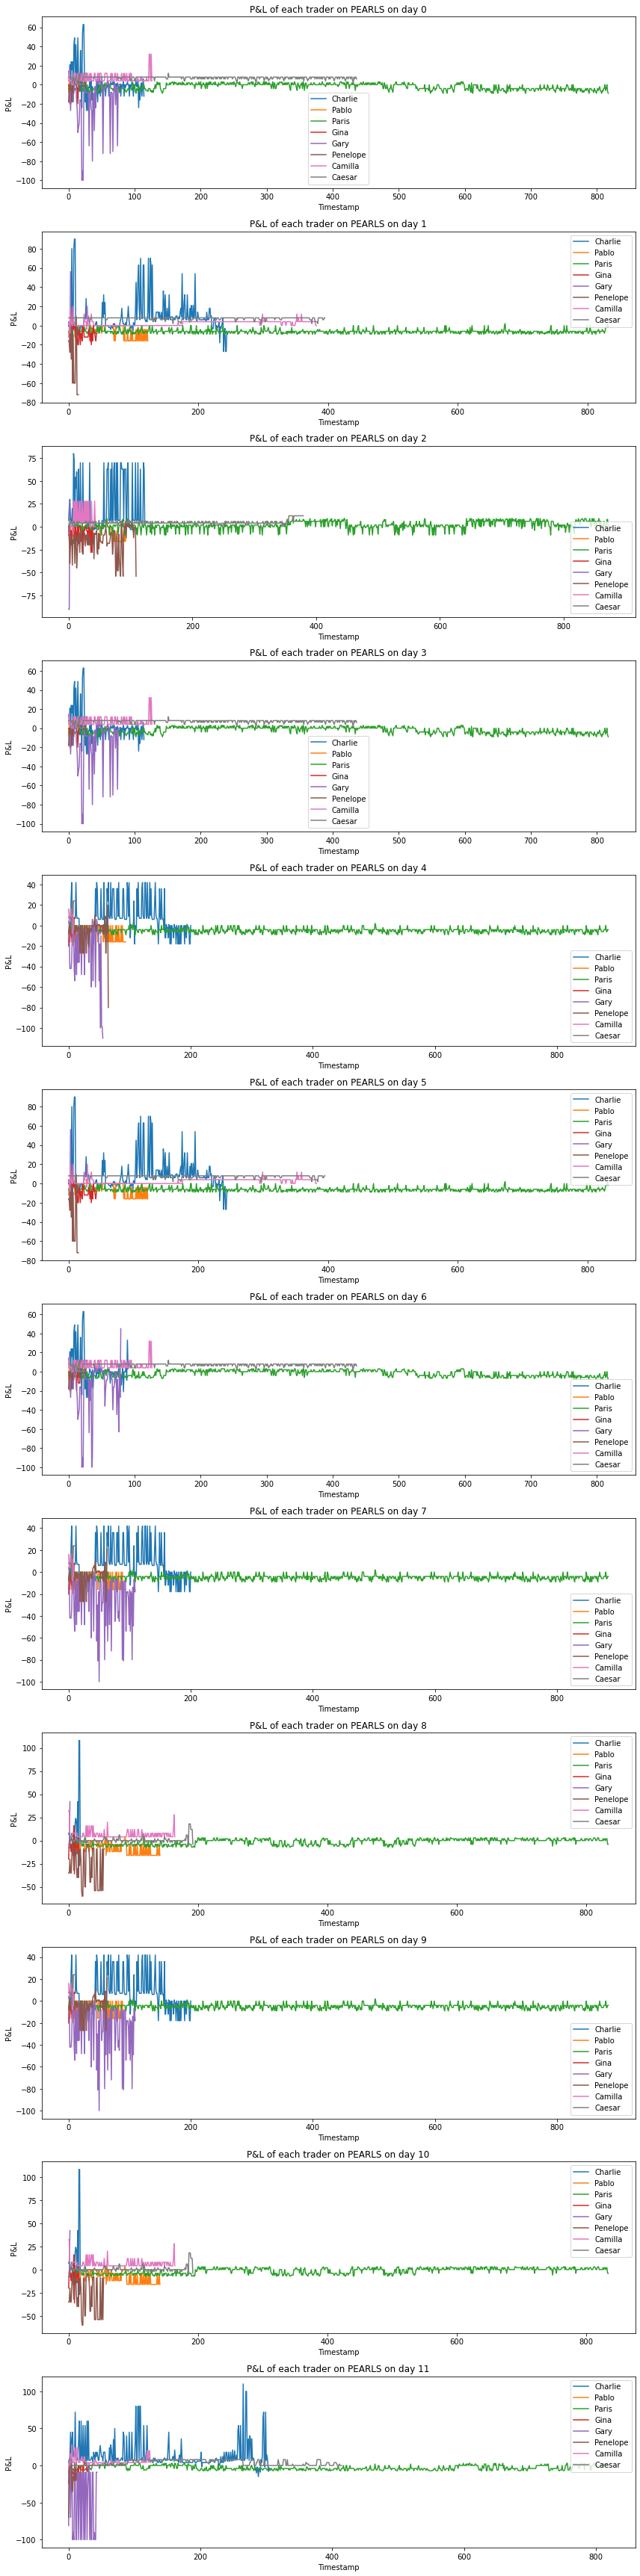

In [236]:
plot_by_product("PEARLS", [df_r1d0, df_r1d1, df_r1d2, df_r2d0, df_r2d1, df_r2d2, df_r3d0, df_r3d1, df_r3d2, df_r4d0, df_r4d1, df_r4d2])

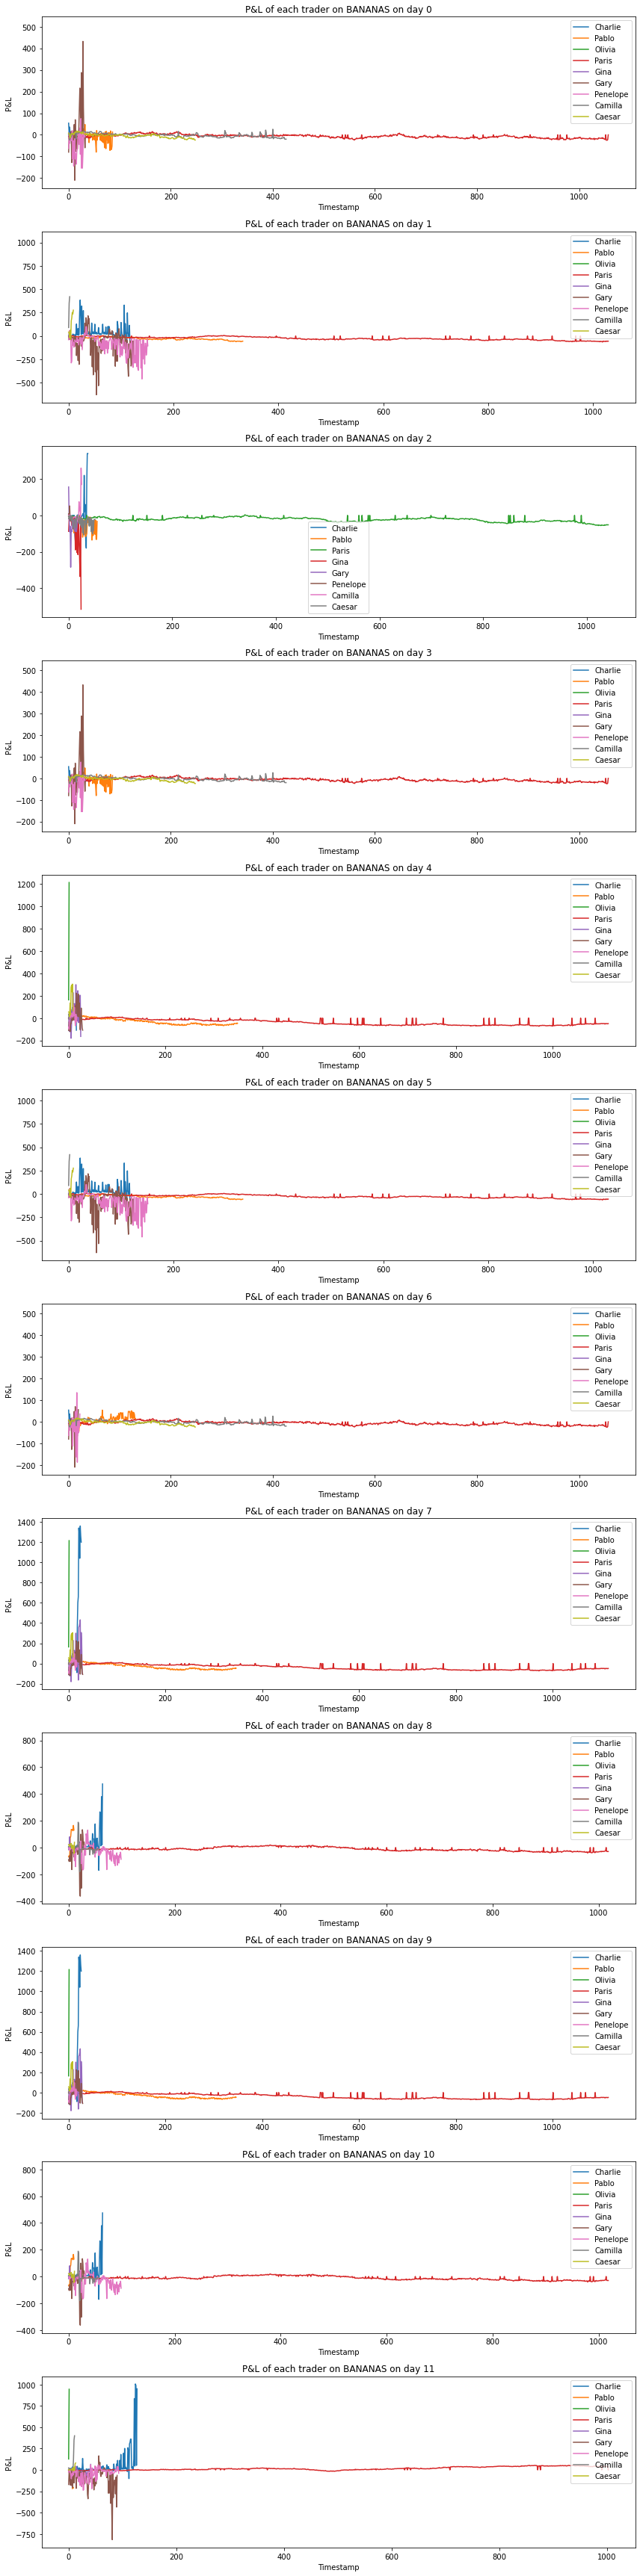

In [237]:
plot_by_product("BANANAS", [df_r1d0, df_r1d1, df_r1d2, df_r2d0, df_r2d1, df_r2d2, df_r3d0, df_r3d1, df_r3d2, df_r4d0, df_r4d1, df_r4d2])

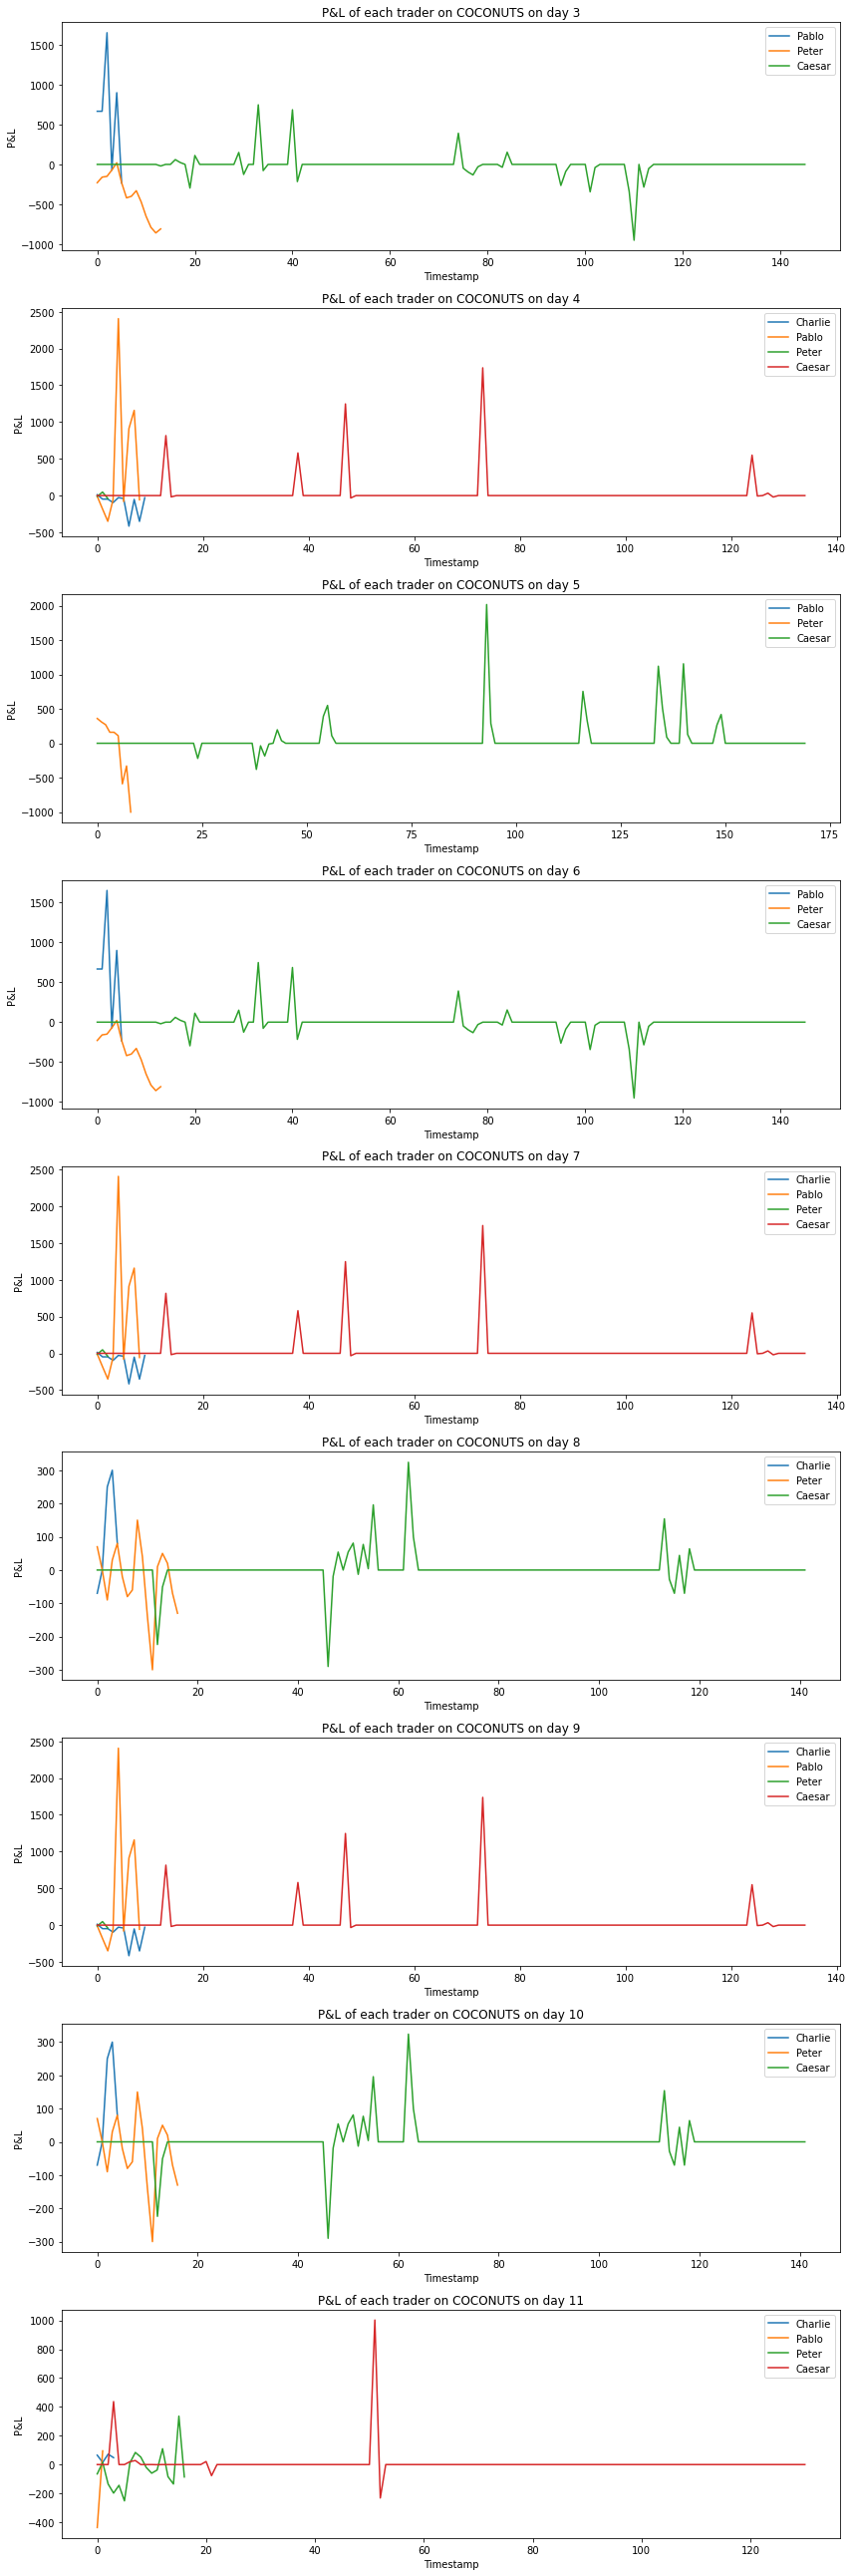

In [240]:
plot_by_product("COCONUTS", [df_r2d0, df_r2d1, df_r2d2, df_r3d0, df_r3d1, df_r3d2, df_r4d0, df_r4d1, df_r4d2], start_day_idx = 3)

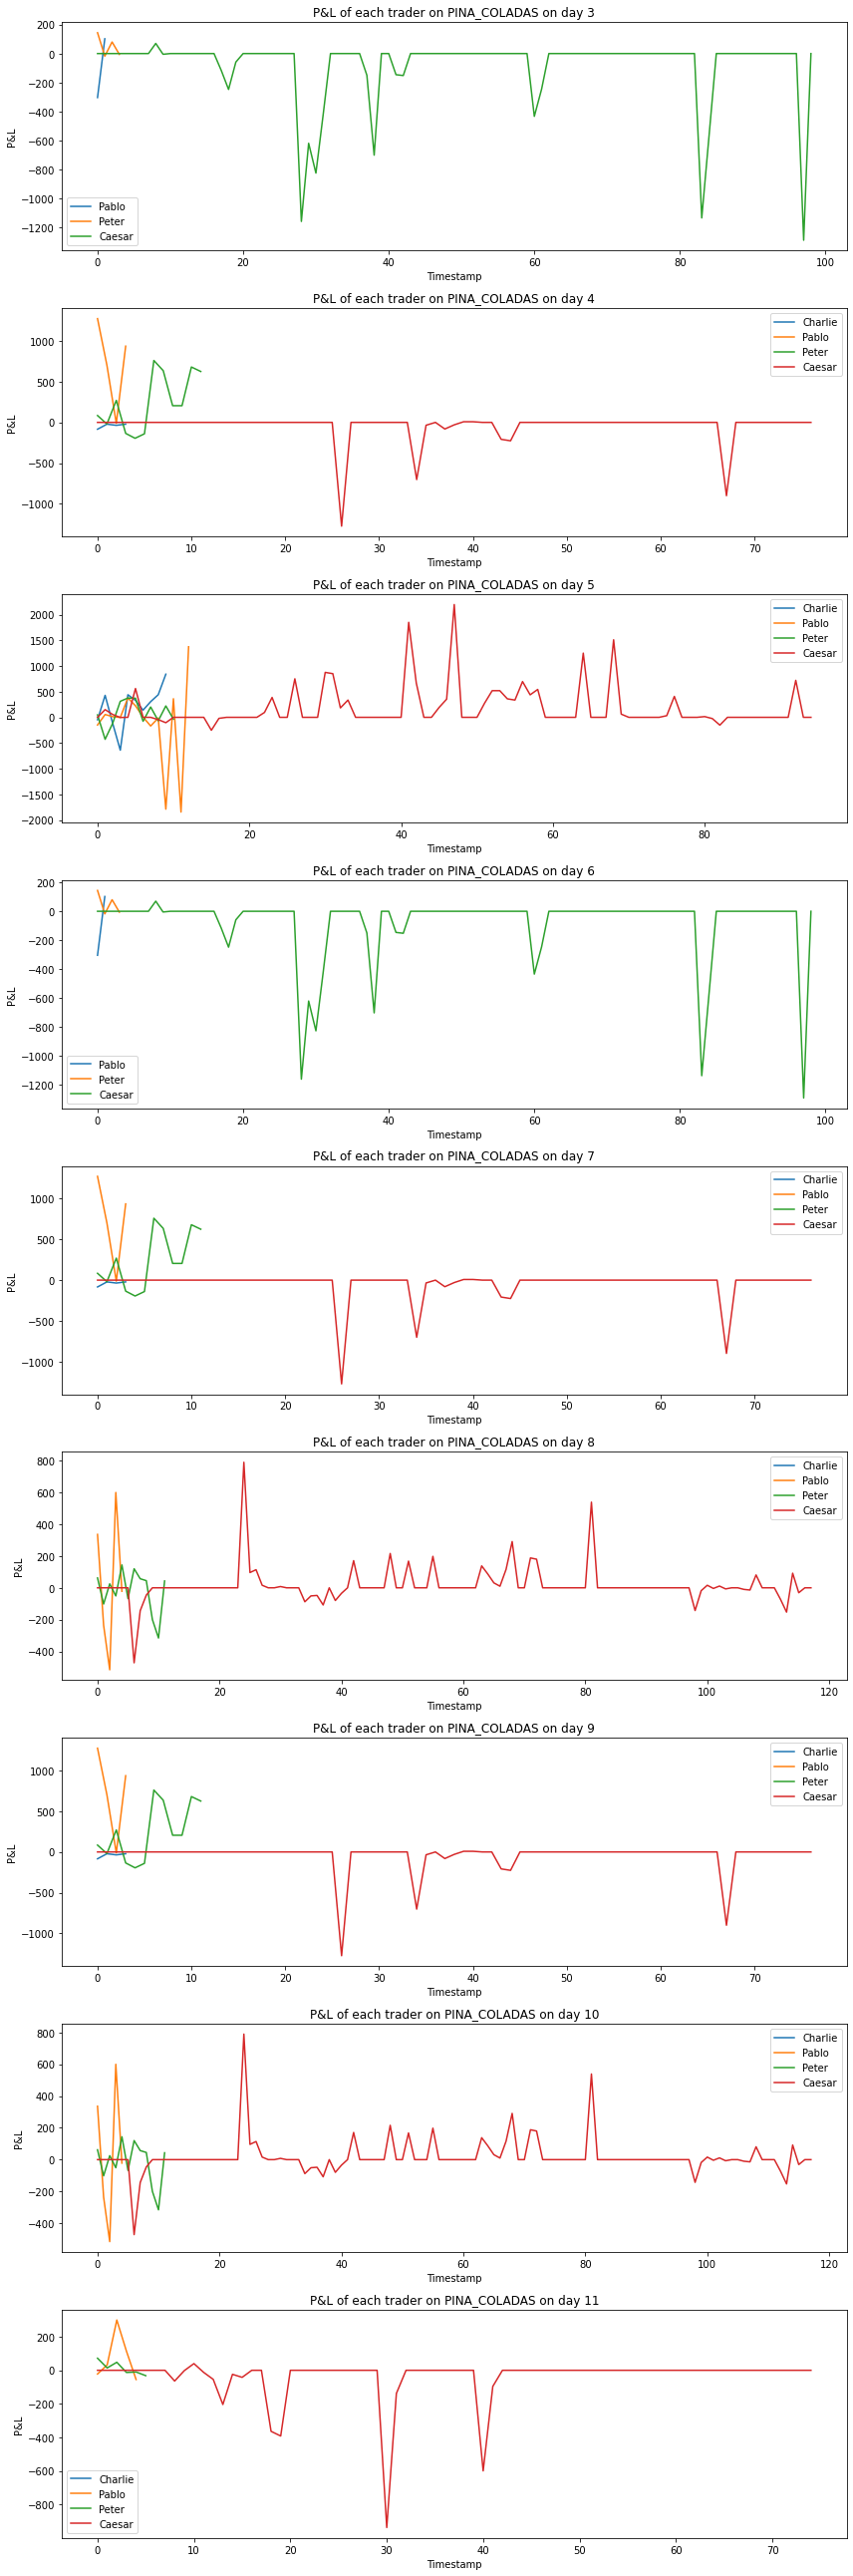

In [241]:
plot_by_product("PINA_COLADAS", [df_r2d0, df_r2d1, df_r2d2, df_r3d0, df_r3d1, df_r3d2, df_r4d0, df_r4d1, df_r4d2], start_day_idx = 3)

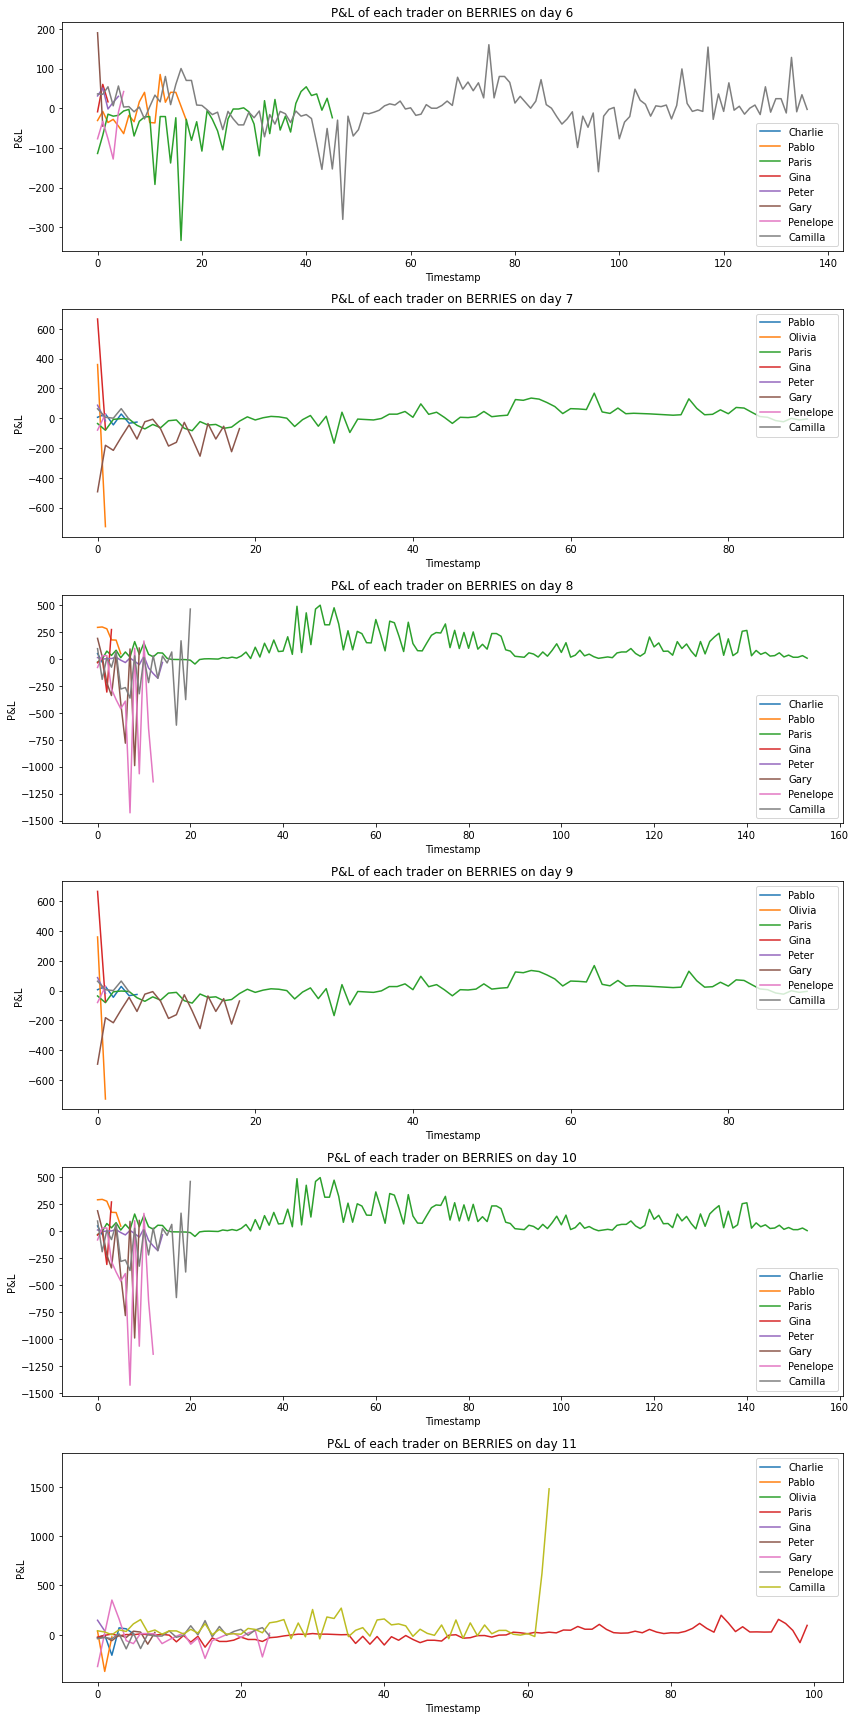

In [242]:
plot_by_product("BERRIES", [df_r3d0, df_r3d1, df_r3d2, df_r4d0, df_r4d1, df_r4d2], start_day_idx = 6)

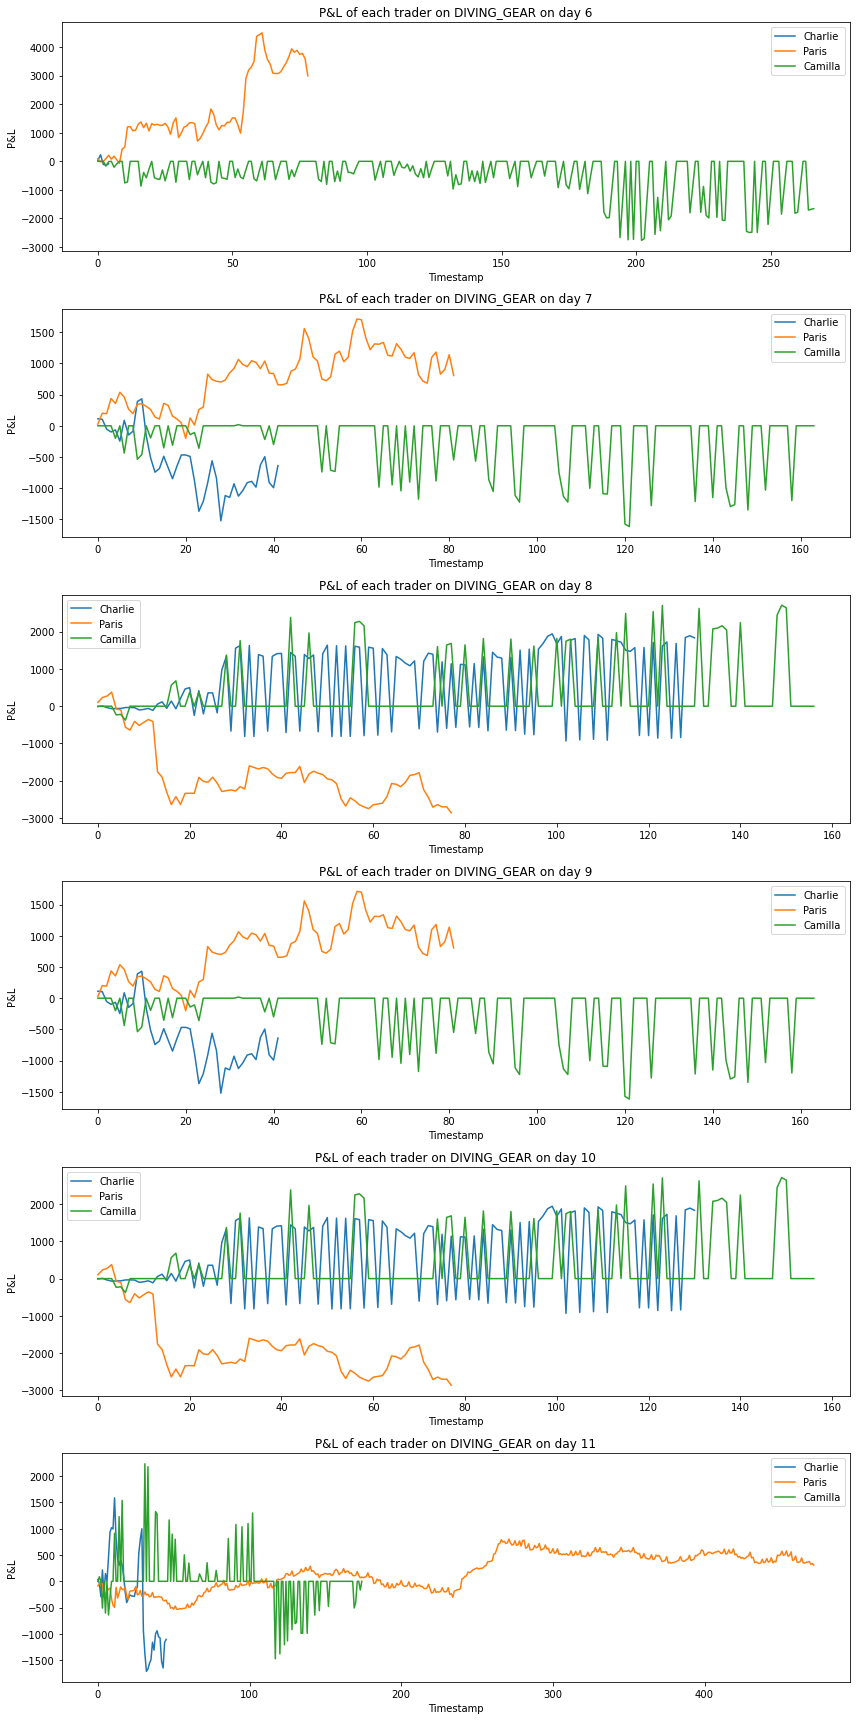

In [243]:
plot_by_product("DIVING_GEAR", [df_r3d0, df_r3d1, df_r3d2, df_r4d0, df_r4d1, df_r4d2], start_day_idx = 6)

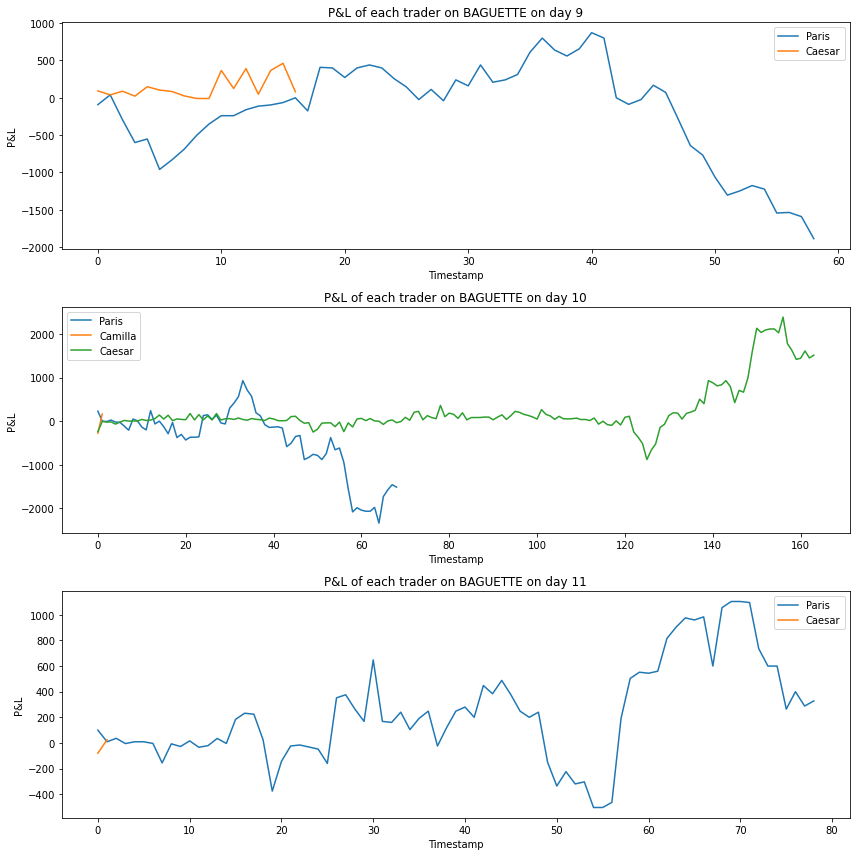

In [244]:
plot_by_product("BAGUETTE", [df_r4d0, df_r4d1, df_r4d2], start_day_idx = 9)

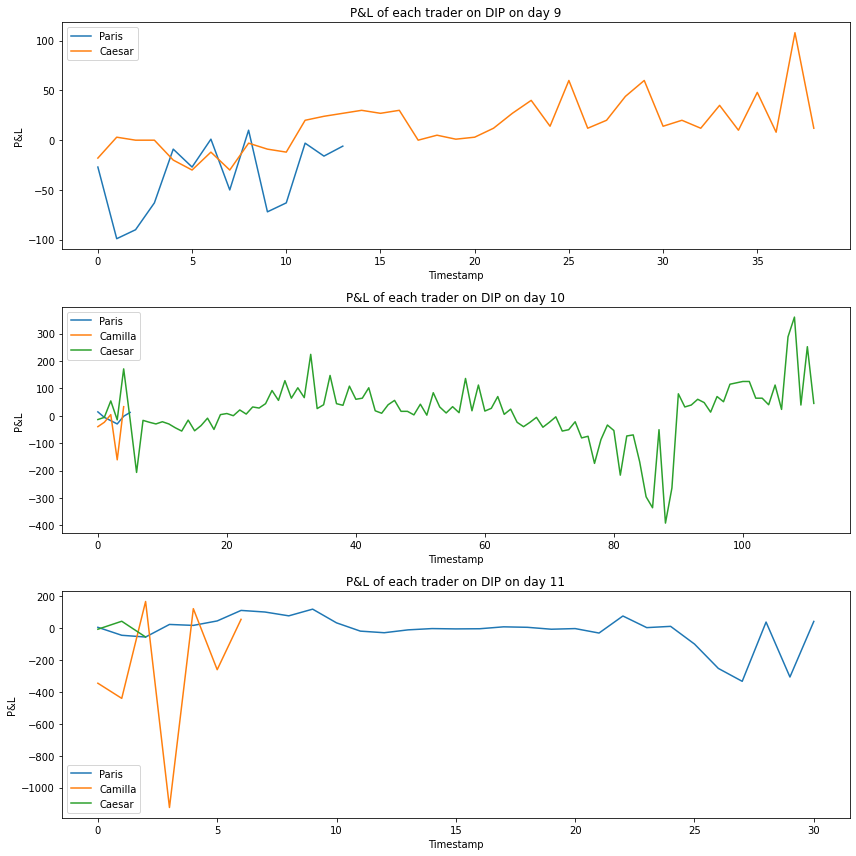

In [245]:
plot_by_product("DIP", [df_r4d0, df_r4d1, df_r4d2], start_day_idx = 9)

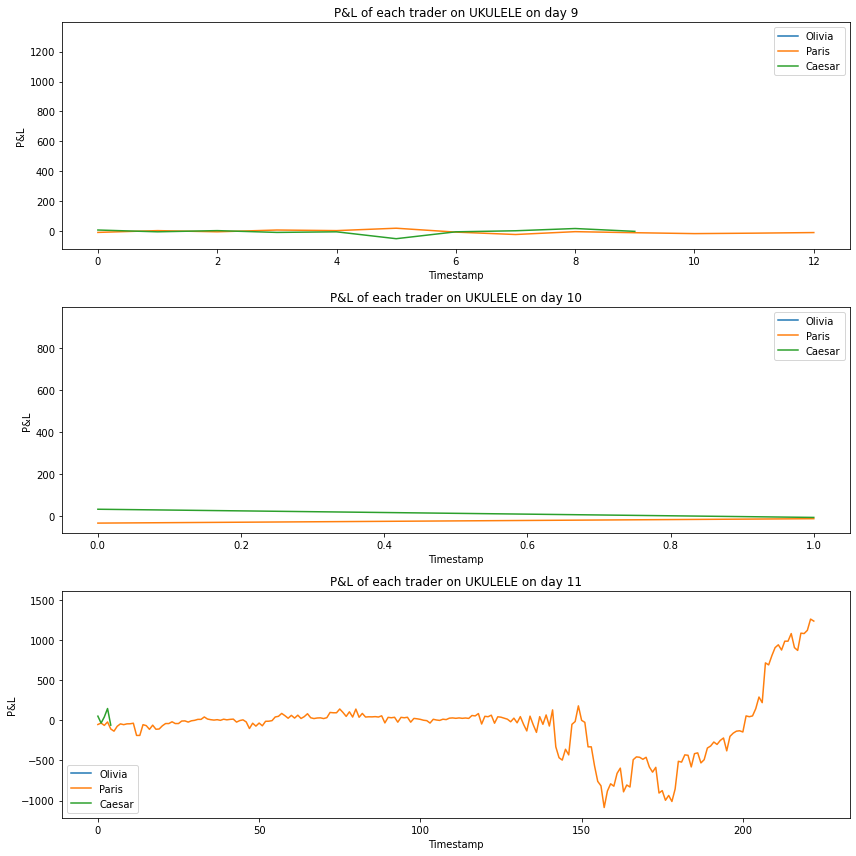

In [246]:
plot_by_product("UKULELE", [df_r4d0, df_r4d1, df_r4d2], start_day_idx = 9)

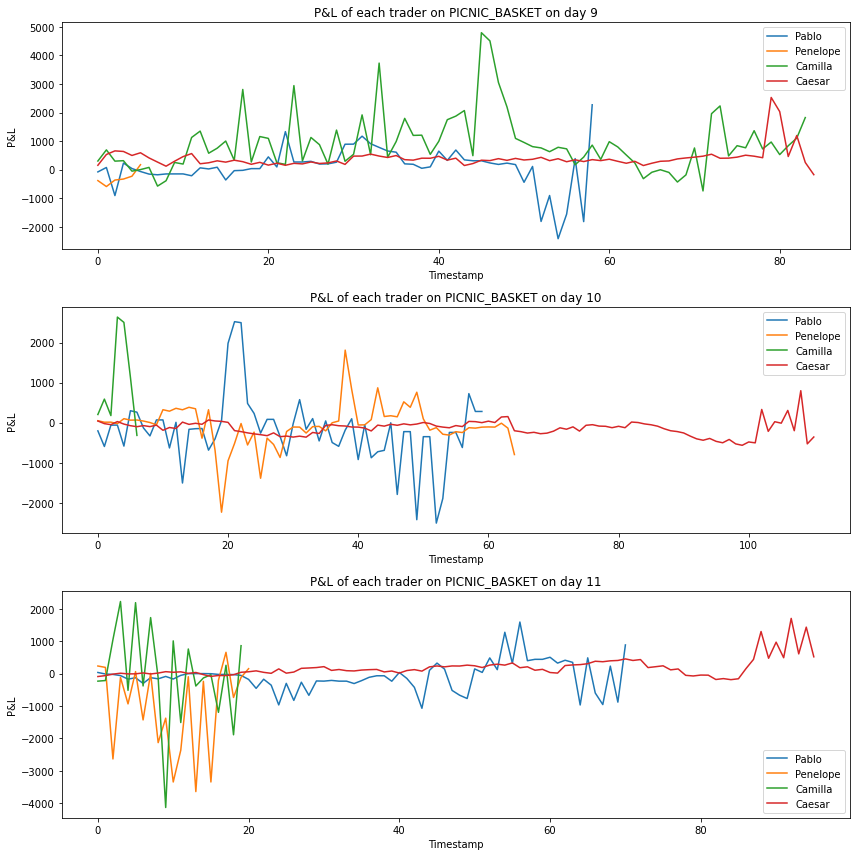

In [247]:
plot_by_product("PICNIC_BASKET", [df_r4d0, df_r4d1, df_r4d2], start_day_idx = 9)